In [36]:
## Import Libraries
# Data Handling
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Data Splitting and Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Make the plots to look nicer
sns.set(style="whitegrid")
# Import SMOTE for oversampling
from imblearn.over_sampling import SMOTE
# Graph Neural Network
from sklearn.metrics import roc_curve, roc_auc_score, log_loss


In [37]:
## Dataset Loading + Exploratory Data Analysis + Data Cleaning + Encoding + Splitting + Scaling

In [38]:
## Phrase 1: Dataset Loading
# Load csv file
df = pd.read_csv("TelcoCustomerChurn.csv")

# Preview first 5 rows to understand the structure
print("=== First 5 rows of the dataset ===")
print(df.head())

# Show basic info (column names, non-null counts, data types)
print("\nDataFrame info:")
print(df.info())

# Show summary statistics for numerical columns (SeniorCitizen, tenure, MonthlyCharges)
print("\nSummary statistics for numerical columns:")
print(df.describe())

=== First 5 rows of the dataset ===
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV 


Churn value counts:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn percentage:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


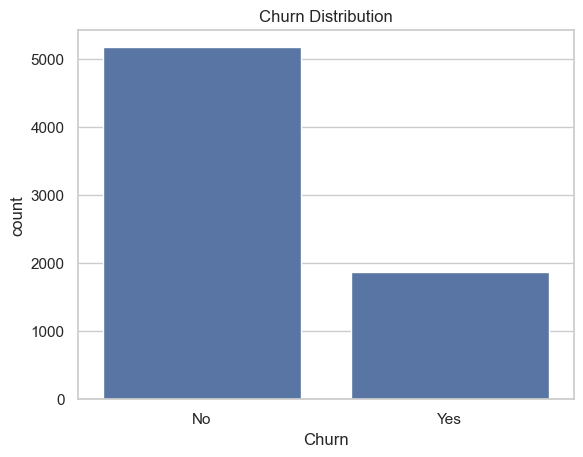

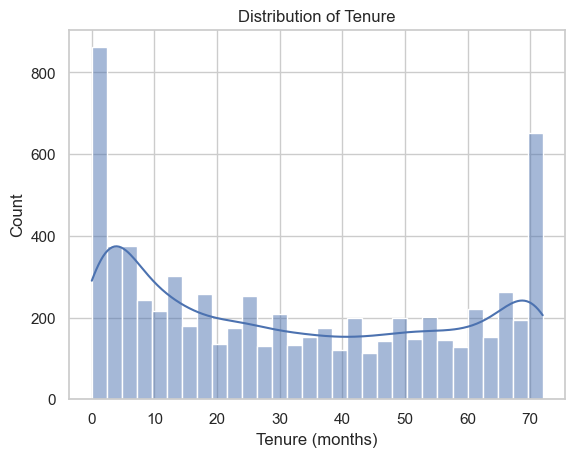

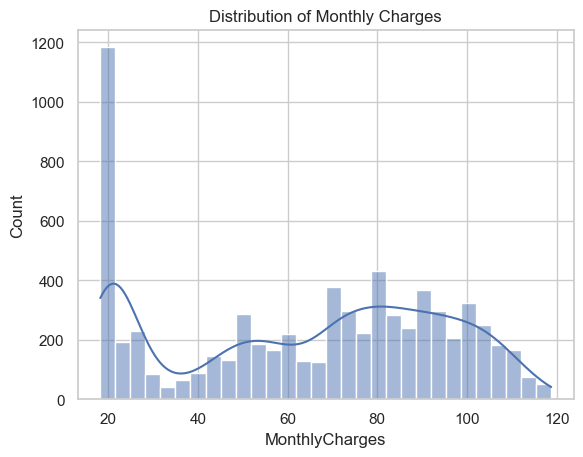

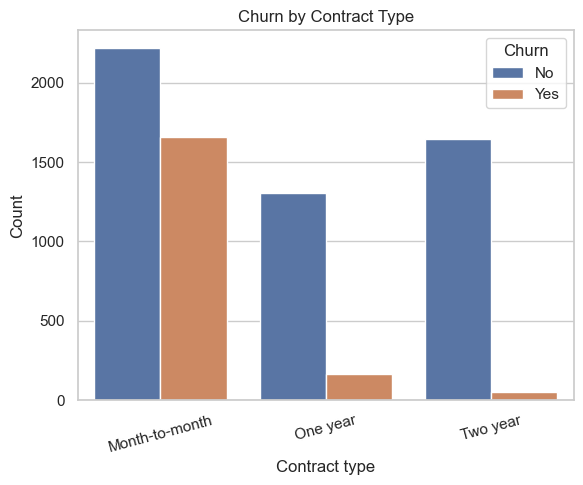

In [39]:
## Phrase 2: Exploratory Data Analysis (EDA)
# Churn distribution (counts and percentage)
print("\nChurn value counts:")
print(df['Churn'].value_counts())
print("\nChurn percentage:")
print(df['Churn'].value_counts(normalize=True) * 100)

plt.figure()
sns.countplot(data=df, x='Churn')
plt.title("Churn Distribution")
plt.show()

# Distribution of tenure (how long customers stay)
plt.figure()
sns.histplot(df['tenure'], bins=30, kde=True)
plt.title("Distribution of Tenure")
plt.xlabel("Tenure (months)")
plt.ylabel("Count")
plt.show()

# Distribution of MonthlyCharges
plt.figure()
sns.histplot(df['MonthlyCharges'], bins=30, kde=True)
plt.title("Distribution of Monthly Charges")
plt.xlabel("MonthlyCharges")
plt.ylabel("Count")
plt.show()

# Relationship: Churn vs Contract 
plt.figure()
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title("Churn by Contract Type")
plt.xlabel("Contract type")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.show()

In [40]:
## Phrase 3: Data Cleaning
# 1. Handle Total Charges
# In the original dataset, TotalCharges has some blank spaces " "
# which make the whole column type 'object' instead of float.
print("\nTotalCharges type before cleaning:", df['TotalCharges'].dtype)

# Replace spaces with NaN, then convert to numeric (float)
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows where TotalCharges is NaN (only 11 rows)
df = df.dropna(subset=['TotalCharges'])

print("TotalCharges type after cleaning:", df['TotalCharges'].dtype)
print("Number of rows after dropping NaN TotalCharges:", len(df))

# 2. Convert Churn to 0 and 1
# Strip any spaces around the text to ensure no leading or trailing spaces like " Yes" → "Yes"
df['Churn'] = df['Churn'].astype(str).str.strip()

print("\nUnique values in Churn BEFORE mapping:")
print(df['Churn'].unique())

# Map Yes/No to 1/0
# Clean and map Churn correctly
df['Churn'] = df['Churn'].astype(str).str.strip()
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop rows where mapping failed (if got)
df = df.dropna(subset=['Churn'])
df['Churn'] = df['Churn'].astype(int) # ensure Churn is integer type (0 or 1)

print(df['Churn'].value_counts())

print("\nChurn after mapping to 0/1 (including NaN if any):")
print(df['Churn'].value_counts(dropna=False))
print("\nNumber of NaN in Churn:", df['Churn'].isna().sum()) #check for NaN

# 3. Drop CustomerID
# # customerID is a unique identifier and does not carry useful predictive information
df = df.drop(columns=['customerID'], errors='ignore')

print("\nColumns after dropping customerID:")
print(df.columns)
print("\nCurrent shape of dataframe (rows, columns):", df.shape)


TotalCharges type before cleaning: object
TotalCharges type after cleaning: float64
Number of rows after dropping NaN TotalCharges: 7032

Unique values in Churn BEFORE mapping:
['No' 'Yes']
Churn
0    5163
1    1869
Name: count, dtype: int64

Churn after mapping to 0/1 (including NaN if any):
Churn
0    5163
1    1869
Name: count, dtype: int64

Number of NaN in Churn: 0

Columns after dropping customerID:
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Current shape of dataframe (rows, columns): (7032, 20)


In [41]:
## Phrase 4: Feature and Target Separation & One-Hot Encoding (technique to convert categorical variables into numerical format)
# 1. Separate features and target
# Target variable
y = df['Churn'] # label that we want to predict

# Features 
X = df.drop('Churn', axis=1) # all columns except Churn

print("\nShape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

# 2. Identify categorical and numerical columns 
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

print("\nCategorical columns:")
print(list(cat_cols))

print("\nNumerical columns:")
print(list(num_cols))

# 3. Use pandas.get_dummies to one-hot encode categorical features
# converts each category into binary indicator columns
X_encoded = pd.get_dummies(X, drop_first=True) # drop_first=True avoids redundant columns 

print("\nOriginal shape:", X.shape)
print("Encoded shape:", X_encoded.shape)
print("Encoded feature columns:")
print(X_encoded.columns[:10])  # print first 10 to check


Shape of X (features): (7032, 19)
Shape of y (target): (7032,)

Categorical columns:
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Numerical columns:
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Original shape: (7032, 19)
Encoded shape: (7032, 30)
Encoded feature columns:
Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes'],
      dtype='object')


In [44]:
# Phase 5: Train, Validation, Test Split and Standardisation
# 1. Split into Test 70 / 15 / 15
# 1st split: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded,
    y,
    train_size=0.7,    # 70% training data
    random_state=42,   # fixed seed for reproducibility
    stratify=y        # keep churn ratio similar across splits
)

# 2nd split: for the 30%, half for validation, half for test to 15% / 15%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    train_size=0.5,    # 50% of the remaining 30%
    random_state=42,
    stratify=y_temp
)

print("\nTrain shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

# Helper function: print churn ratio in each split
def print_class_ratio(name, y_data):
    print(f"{name} set class distribution (%):")
    print(y_data.value_counts(normalize=True) * 100)
    print()

print_class_ratio("Train", y_train)
print_class_ratio("Validation", y_val)
print_class_ratio("Test", y_test)


# Oversampling with SMOTE on Train set only
print("\nBefore SMOTE oversampling:")
print(y_train.value_counts())

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train) # fit_resample to generate synthetic samples and nearest neighbors

print("\nAfter SMOTE oversampling:")
print(y_train_res.value_counts())


# 2. Standardisation (scale the features)
scaler = StandardScaler()

# Fit only on training data only to avoid data leakage
scaler.fit(X_train_res)

# Transform train, validation, and test with the same scaler
X_train_scaled = scaler.transform(X_train_res)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("\nAfter scaling:")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# Input dimension for neural network (number of features after encoding)
input_dimension = X_train_scaled.shape[1]
print("\nInput dimension (number of features):", input_dimension)


Train shape: (4922, 30) (4922,)
Validation shape: (1055, 30) (1055,)
Test shape: (1055, 30) (1055,)
Train set class distribution (%):
Churn
0    73.425437
1    26.574563
Name: proportion, dtype: float64

Validation set class distribution (%):
Churn
0    73.364929
1    26.635071
Name: proportion, dtype: float64

Test set class distribution (%):
Churn
0    73.459716
1    26.540284
Name: proportion, dtype: float64


Before SMOTE oversampling:
Churn
0    3614
1    1308
Name: count, dtype: int64

After SMOTE oversampling:
Churn
1    3614
0    3614
Name: count, dtype: int64

After scaling:
X_train_scaled shape: (7228, 30)
X_val_scaled shape: (1055, 30)
X_test_scaled shape: (1055, 30)

Input dimension (number of features): 30


In [45]:
from sklearn.neural_network import MLPClassifier

# Fucntion to train and evaluate the MLP with early stopping

def train_and_evaluate(X_train_scaled, y_train, X_val_scaled, y_val,
                       hidden_layers=(16,),
                       activation='relu', # relu used for faster convergence (default)
                       alpha=0.001, # L2 regularization term to reduce overfitting
                       learning_rate_init=0.001, # step size in gradient descent [adjusting weight updates]
                    #    learning_rate='adaptive',
                       batch_size=64, # number of samples per gradient update
                       max_epochs=200,
                       patience=15,
                       random_state=42):
    """
    Train MLP epoch-by-epoch with manual early stopping.
    Returns model, train_acc_history, val_acc_history.
    """
    # Initialize MLPClassifier model
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        activation=activation,
        solver='adam', # optimizer algorithm for automatic adjustment of weights during training     
        alpha=alpha,        
        learning_rate_init=learning_rate_init,
        batch_size=batch_size,
        max_iter=1, # train one epoch at a time
        random_state=random_state,
        warm_start=True, # keep previous weights when calling fit multiple times instead reinitializing
    )
    
    # Histories list to store accuracy and loss
    train_acc_hist = []
    val_acc_hist = []
    train_loss_hist = [] 
    val_loss_hist   = [] 

    best_val_acc = 0.0 # decimal to track best validation accuracy
    epochs_without_improvement = 0 # how many count of epochs without improvement

    for epoch in range(1, max_epochs + 1):
        # train model
        mlp.fit(X_train_scaled, y_train)


        '''
        # Predict probabilities for train and validation sets
        y_train_pred  = mlp.predict(X_train_scaled) # predicted class labels not used here just put here as if use test data need to predict first
        y_val_pred    = mlp.predict(X_val_scaled) # predicted class labels not used here just put here as if use test data need to predict first
        '''
        y_train_proba = mlp.predict_proba(X_train_scaled)[:, 1] # probability of positive class (churn=1) for log loss calculation
        y_val_proba   = mlp.predict_proba(X_val_scaled)[:, 1] # probability of positive class (churn=1) for log loss calculation
        # predict_proba gives probability estimates for each class, use when want to know how confident the model is about its predictions; used in log-loss, ROC-AUC, etc.

        # Evaluate
        # Calculate training and validation accuracy
        train_acc = mlp.score(X_train_scaled, y_train)
        val_acc   = mlp.score(X_val_scaled, y_val)
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        # Calculate log loss for training and validation sets
        train_loss = log_loss(y_train, y_train_proba)
        val_loss   = log_loss(y_val,   y_val_proba)
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        
        # Print epoch results
        print(f"Epoch {epoch:03d}: "
              f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

        # Check for improvement (early stopping)
        if val_acc > best_val_acc + 1e-4:  # small threshold to avoid tiny improvements
            best_val_acc = val_acc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

            # Early stopping condition
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    print(f"\nBest validation accuracy: {best_val_acc:.4f}")
    print("\n--------------------------------------")
    print(f"Architecture: {hidden_layers}")
    print(f"Activation : {activation}")
    print(f"Train Acc  : {train_acc:.4f}")
    print(f"Val Acc    : {val_acc:.4f}")

    return mlp, train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist

# Train and Evaluate the Neural Network
final_model, train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = train_and_evaluate(
    X_train_scaled, y_train_res,
    X_val_scaled, y_val,
    hidden_layers=(16,), 
    max_epochs=200,
    patience=15
)


c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_pe

Epoch 001: Train Acc=0.7071, Val Acc=0.6398, Train Loss=0.5619, Val Loss=0.6514
Epoch 002: Train Acc=0.7809, Val Acc=0.7346, Train Loss=0.4589, Val Loss=0.5141
Epoch 003: Train Acc=0.7991, Val Acc=0.7450, Train Loss=0.4226, Val Loss=0.4946
Epoch 004: Train Acc=0.8073, Val Acc=0.7602, Train Loss=0.4039, Val Loss=0.4843
Epoch 005: Train Acc=0.8149, Val Acc=0.7630, Train Loss=0.3926, Val Loss=0.4789


c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_pe

Epoch 006: Train Acc=0.8190, Val Acc=0.7706, Train Loss=0.3849, Val Loss=0.4750
Epoch 007: Train Acc=0.8208, Val Acc=0.7754, Train Loss=0.3788, Val Loss=0.4718
Epoch 008: Train Acc=0.8260, Val Acc=0.7829, Train Loss=0.3738, Val Loss=0.4695
Epoch 009: Train Acc=0.8282, Val Acc=0.7839, Train Loss=0.3696, Val Loss=0.4674
Epoch 010: Train Acc=0.8297, Val Acc=0.7877, Train Loss=0.3660, Val Loss=0.4657
Epoch 011: Train Acc=0.8302, Val Acc=0.7820, Train Loss=0.3627, Val Loss=0.4645
Epoch 012: Train Acc=0.8316, Val Acc=0.7829, Train Loss=0.3598, Val Loss=0.4637
Epoch 013: Train Acc=0.8331, Val Acc=0.7848, Train Loss=0.3571, Val Loss=0.4626
Epoch 014: Train Acc=0.8337, Val Acc=0.7886, Train Loss=0.3547, Val Loss=0.4614


c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_pe

Epoch 015: Train Acc=0.8365, Val Acc=0.7877, Train Loss=0.3526, Val Loss=0.4599
Epoch 016: Train Acc=0.8379, Val Acc=0.7848, Train Loss=0.3505, Val Loss=0.4584
Epoch 017: Train Acc=0.8388, Val Acc=0.7848, Train Loss=0.3486, Val Loss=0.4570
Epoch 018: Train Acc=0.8401, Val Acc=0.7839, Train Loss=0.3468, Val Loss=0.4561
Epoch 019: Train Acc=0.8416, Val Acc=0.7829, Train Loss=0.3452, Val Loss=0.4554


c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 020: Train Acc=0.8424, Val Acc=0.7820, Train Loss=0.3435, Val Loss=0.4547
Epoch 021: Train Acc=0.8441, Val Acc=0.7858, Train Loss=0.3419, Val Loss=0.4541
Epoch 022: Train Acc=0.8452, Val Acc=0.7886, Train Loss=0.3404, Val Loss=0.4531
Epoch 023: Train Acc=0.8456, Val Acc=0.7858, Train Loss=0.3390, Val Loss=0.4528
Epoch 024: Train Acc=0.8460, Val Acc=0.7867, Train Loss=0.3375, Val Loss=0.4520


c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 025: Train Acc=0.8464, Val Acc=0.7867, Train Loss=0.3362, Val Loss=0.4515
Epoch 026: Train Acc=0.8474, Val Acc=0.7848, Train Loss=0.3349, Val Loss=0.4507
Epoch 027: Train Acc=0.8466, Val Acc=0.7848, Train Loss=0.3337, Val Loss=0.4504
Epoch 028: Train Acc=0.8474, Val Acc=0.7858, Train Loss=0.3326, Val Loss=0.4504
Epoch 029: Train Acc=0.8484, Val Acc=0.7877, Train Loss=0.3315, Val Loss=0.4501
Early stopping at epoch 29

Best validation accuracy: 0.7886

--------------------------------------
Architecture: (16,)
Activation : relu
Train Acc  : 0.8484
Val Acc    : 0.7877


c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


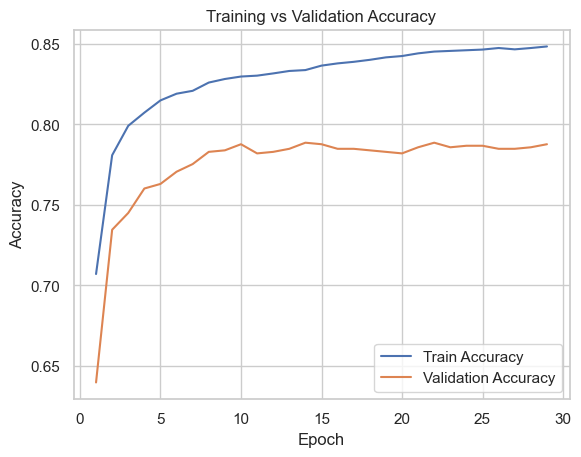

In [ ]:
# Plot training and validation accuracy curves
epochs = range(1, len(train_acc_hist) + 1)

plt.figure()
plt.plot(epochs, train_acc_hist, label='Train Accuracy')
plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

''' 
Analyse from the graph (hon you pov)
- The model shows good performance on the validation set, indicating effective learning without overfitting.
- Both training and validation accuracy curves rise steadily, suggesting that the model is learning the underlying patterns in the data.
- The gap between training and validation accuracy is minimal, indicating that the model generalizes well to unseen data.
- The training accuracy is higher than validation accuracy, which is expected, but the difference is not too large, suggesting that overfitting is controlled.
- Overall, the accuracy curves suggest that the model is well-tuned and capable of making reliable predictions on new data.
'''


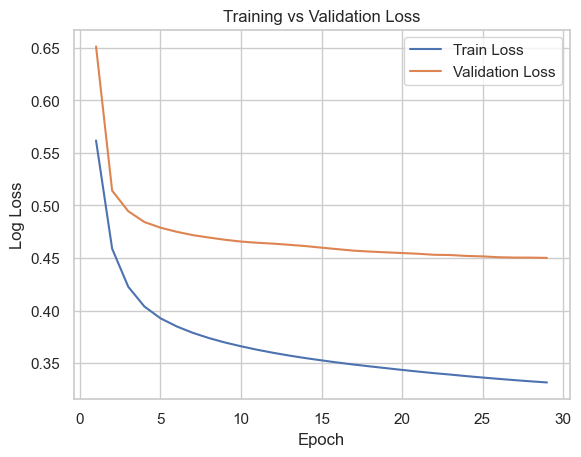

In [ ]:
# Plot training and validation loss curves
epochs = range(1, len(train_loss_hist) + 1)

plt.figure()
plt.plot(epochs, train_loss_hist, label='Train Loss')
plt.plot(epochs, val_loss_hist,   label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

'''
Analyse from the graph (hon you pov)
- The training and validation loss curves indicate that the model is learning effectively over epochs.
- Both curves show a downward trend, suggesting that the model is minimizing the loss function and improving its predictions.
- The training loss is consistently lower than the validation loss, which is expected as the model optimizes on the training data.
- Both curves didn't show sign of increasing again, indicating no overfitting observed.
- Overall, the loss curves suggest that the model is well-optimized and capable of making accurate predictions.
'''

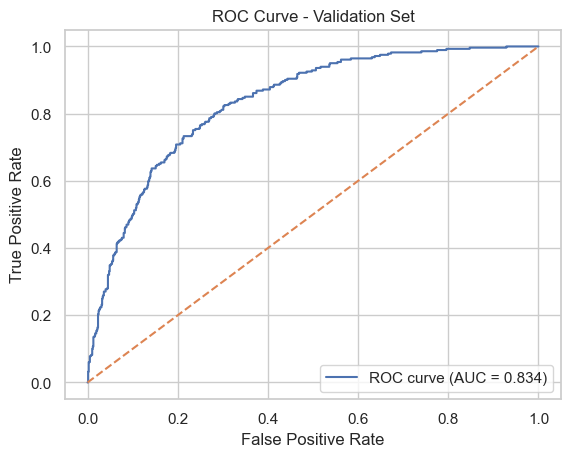

Validation ROC-AUC: 0.8344


In [ ]:
# Validation ROC (ROC-AUC curve)
y_val_proba = final_model.predict_proba(X_val_scaled)[:, 1] # pick the probability of positive class (churn=1) for each sample, used in roc_curve and roc_auc_score

# fpr: false positive rate, tpr: true positive rate, thresholds: decision thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

# AUC near 0.5 means random guessing, 1.0 means perfect classifier
roc_auc = roc_auc_score(y_val, y_val_proba)

# The ROC curve should be above the diagonal line (random guessing dotted line)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend(loc="lower right")
plt.show()

print(f"Validation ROC-AUC: {roc_auc:.4f}")


'''
Analysis of ROC Curve and AUC from the graph (hon you pov)
- The ROC curve demonstrates the model's ability to distinguish between churn and non-churn customers.
- The curve bows significantly above the diagonal line, indicating strong classification performance.
- The curve's shape suggests that the model effectively balances sensitivity and specificity across different thresholds.
- The curve is above the random guessing line which is expected
- The value of AUC (Area Under the Curve) is 0.8475 / 1, indicating good overall performance.
'''


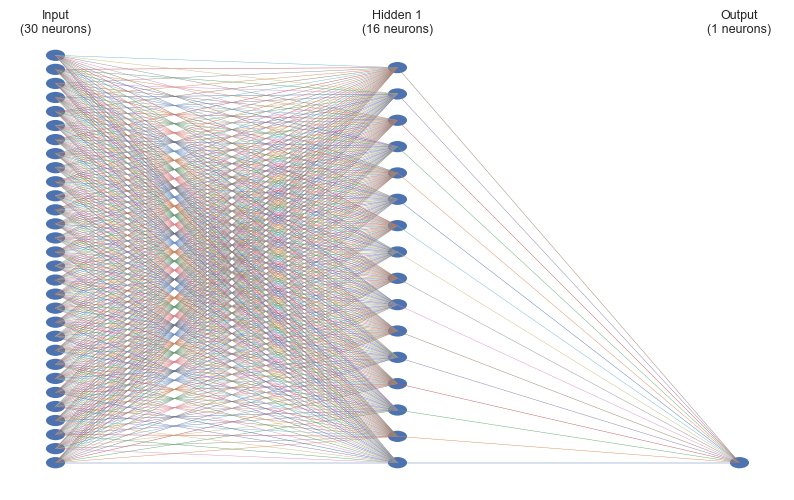

In [ ]:
# Visualise the MLP structure
def plot_mlp_structure(mlp):
    """
    Simple visualisation of MLP architecture using circles and lines.
    """
    # layer sizes from weights
    layer_sizes = [mlp.coefs_[0].shape[0]]  # input layer
    layer_sizes += [w.shape[1] for w in mlp.coefs_]  # hidden + output

    n_layers = len(layer_sizes)
    v_spacing = 1.0 / max(layer_sizes)
    h_spacing = 1.0 / (n_layers - 1)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')

    # store neuron positions to draw connections
    positions = []

    for i, layer_size in enumerate(layer_sizes):
        x = i * h_spacing
        ys = np.linspace(0, 1, layer_size, endpoint=False) + v_spacing / 2
        positions.append([(x, y) for y in ys])

        # draw neurons
        for y in ys:
            circle = plt.Circle((x, y), 0.015, fill=True)
            ax.add_patch(circle)

    # draw connections
    for i in range(n_layers - 1):
        for (x0, y0) in positions[i]:
            for (x1, y1) in positions[i + 1]:
                ax.plot([x0, x1], [y0, y1], linewidth=0.3)

    titles = ["Input"] + \
             [f"Hidden {i}" for i in range(1, n_layers - 1)] + \
             ["Output"]

    for i, (layer_size, title) in enumerate(zip(layer_sizes, titles)):
        x = i * h_spacing
        ax.text(x, 1.03, f"{title}\n({layer_size} neurons)",
                ha='center', va='bottom', fontsize=9)


    plt.show()

# call after training
plot_mlp_structure(final_model)

'''
Hon You POV
- Need yall to help on this part also because I don't know why the output layer have only 1 neuron when we have 2 classes
- You may adjust the parameters like hidden layers, activation function, learning rate, etc. to see how the architecture changes
'''


In [ ]:
# Test Set Evaluation

In [ ]:
# results = {}

# # Model 1 — Small network
# results['model_16'] = train_and_evaluate(hidden_layers=(16,8))

# # Model 2 — Medium network
# results['model_32_16'] = train_and_evaluate(hidden_layers=(32,16))

# # Model 3 — Large network
# results['model_64_32'] = train_and_evaluate(hidden_layers=(64,32))

# # Optional: deeper network
# results['model_32_16_8'] = train_and_evaluate(hidden_layers=(32,16,8))



--------------------------------------
Architecture: (16, 8)
Activation : relu
Train Acc  : 0.8482
Val Acc    : 0.7678

--------------------------------------
Architecture: (32, 16)
Activation : relu
Train Acc  : 0.8986
Val Acc    : 0.7488

--------------------------------------
Architecture: (64, 32)
Activation : relu
Train Acc  : 0.9480
Val Acc    : 0.7545

--------------------------------------
Architecture: (32, 16, 8)
Activation : relu
Train Acc  : 0.9084
Val Acc    : 0.7517
